In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa
import sys
import libfmp.b
import libfmp.c3
import libfmp.c4
import libfmp.c5
%matplotlib inline



## Dataset
The chords of 4 Beatles songs were analyzed. Due to the complexities and relationships of similar chords, such as diminished and augmented chords, certain chords were simplified to be either major or minor chords.

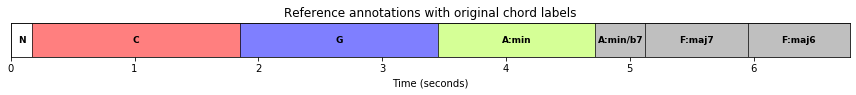

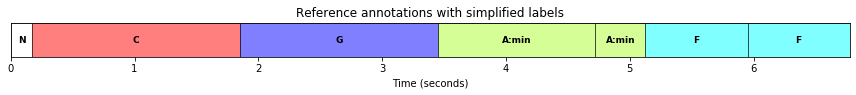

In [2]:
## Read Files
sys.path.append('..')
annotated_original=os.path.join('Sounds','Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords.csv')
annotated_simplified=os.path.join('Sounds','Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords_simplified.csv')

orig,_ = libfmp.c4.read_structure_annotation(annotated_original)
simp, _ = libfmp.c4.read_structure_annotation(annotated_simplified)


# Chord Annotations
color_ann = {'N': 'white', 
         'C': 'red', 'C#': 'peru', 'D': 'orange', 'D#': 'yellow', 'Eb': 'yellow', 
         'E': 'springgreen', 'F': 'cyan', 'F#': 'coral', 'G': 'blue', 
            'G#': 'olive', 'A': 'teal', 'A#': 'indigo', 'Bb': 'indigo', 'B': 'pink',
         'C#:min': 'steelblue', 'C#m': 'steelblue', 'A:min': 'greenyellow', 'A:m': 'greenyellow',
            'G:min': 'olive', 'E:min': 'lightcoral', 'B:min': 'saddlebrown'
         }
chord_labels=libfmp.c5.get_chord_labels(ext_minor='m',nonchord=False)
libfmp.b.plot_segments(orig[:7],figsize=(12,1.2),time_label='Time (seconds)', 
                       fontsize=9, colors=color_ann, alpha=0.5)

plt.title('Reference annotations with original chord labels')
plt.show()
libfmp.b.plot_segments(simp[:7], figsize=(12, 1.2), time_label='Time (seconds)', 
                       fontsize=9, colors=color_ann, alpha=0.5)
plt.title('Reference annotations with simplified labels')
plt.show()

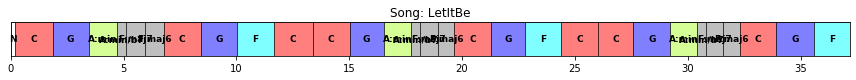

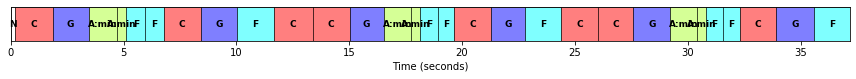

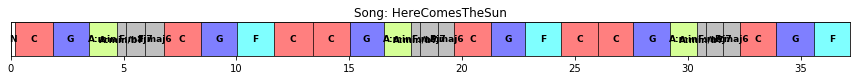

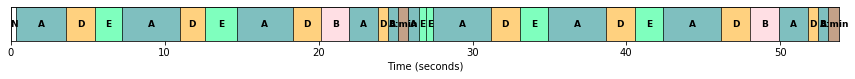

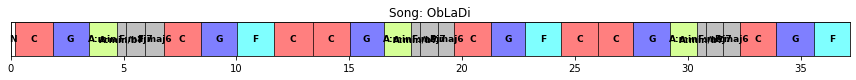

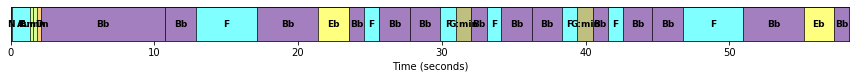

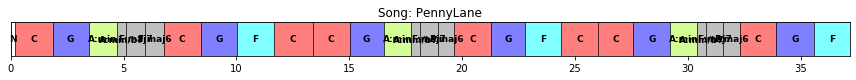

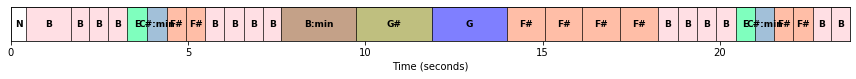

In [3]:
#View original and simplified chord labels of each song

songs={}

songs[0]=['LetItBe', 'r', 
         os.path.join('Sounds','Beatles_LetItBe_Beatles_1970-LetItBe-06.wav'),
         os.path.join('Sounds','Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords_simplified.csv')]

songs[1]=['HereComesTheSun', 'b', 
         os.path.join('Sounds','Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav'),
         os.path.join('Sounds','Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07_Chords_simplified.csv')]

songs[2]=['ObLaDi', 'c', 
         os.path.join('Sounds','Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04.wav'),
         os.path.join('Sounds',
                      'Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04_Chords_simplified.csv')]

songs[3]=['PennyLane', 'g', 
         os.path.join('Sounds','Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09.wav'),
         os.path.join('Sounds','Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09_Chords_simplified.csv')]


chord_labels=libfmp.c5.get_chord_labels(ext_minor='m',nonchord=False)

for key in songs.keys():
    name = songs[key][0]
    annotated=songs[key][3]
    annotated_original=annotated.replace('_simplified','')
    
#     orig,_=libfmp.c4.read_structure_annotation(annotated_original)
    simp,_=libfmp.c4.read_structure_annotation(annotated)
    
    libfmp.b.plot_segments(orig[:30], figsize=(12, 1), 
                           fontsize=9, colors=color_ann, alpha=0.5)
    plt.title('Song: %s' % name)
    plt.show()
    libfmp.b.plot_segments(simp[:30], figsize=(12, 1.2), time_label='Time (seconds)', 
                           fontsize=9, colors=color_ann, alpha=0.5)
    plt.show()

# Feature Extraction
For typical chord recognition approaches, the raw audio format is first converted into a series of chromagram audio features. Three different chromagrams were used: 
 - Discrete Short-Time Fourier Transform (STFT) Chroma and log compression
 - Constant Q (CQT) Chroma
 - IIR Chroma features with Chroma binning and log compression
 
Each audio is sampled at 22050 Hz. For STFT, a window size of 2048 samples were used, with a hop size of 1024 samples, leading to a feature rate of 21.5 Hz. These values were used for IIR time-frequency response as well. Same hop size was used for the CQT. All chromagrams were normalized to the Euclidean norm.


In [4]:
def extract_features(selected_song,feature='stft',verbose=True):
    """
    Args:
        selected_song (ndarray): wav file and related directory to chord labels 
        feature (string): type of chromagram
    
    Return:
        extraction (dict): Chromgram output
        fs_dict (dict): Frequency of each window
        annotations (dict): Time window of each chord labels 
        chord_hmm (ndarray): HMM based chord recognition 
        chord_labels (list): All possible chord labels
    """
    extraction={}
    fs_dict={}
    annotations={}
    dur={}
    chord_labels=libfmp.c5.get_chord_labels(ext_minor='m',nonchord=False)
    
    for item in selected_song:
        if verbose:
            print('Extracting Features from {}'.format(songs[item][0]))
        wav=songs[item][2]
        annotated=songs[item][3]
        n=2048
        h=1024
        if feature=='stft':
            X,Fs_X,x,Fs,x_dur=libfmp.c5.compute_chromagram_from_filename(wav, N=n, H=h, gamma=0.1, version='STFT')
        if feature=='cqt':
            X,Fs_X,x,Fs,x_dur=libfmp.c5.compute_chromagram_from_filename(wav,H=h, version='CQT')
        if feature=='iir':
            X,Fs_X,x,Fs,x_dur=libfmp.c5.compute_chromagram_from_filename(wav, N=n, H=h, gamma=10, version='IIR')
    
        extraction[item]=X
        fs_dict[item]=Fs_X
        dur[item]=x_dur
        n_x=X.shape[1]
        annotations[item]=libfmp.c5.convert_chord_ann_matrix(annotated, chord_labels, Fs=Fs_X, N=n_x, last=False)
    return extraction, fs_dict, annotations, dur, chord_labels

selected_song=[0,1,2,3]
print('--------- STFT Based chromagarams ---------')
extraction_stft, fs_stft, annotations_stft, dur, chord_labels = extract_features(selected_song, feature='stft')
print('--------- CQT4 Based chromagarams ---------')
extraction_cqt, fs_cqt, annotations_cqt, dur, chord_labels = extract_features(selected_song, feature='cqt')
print('--------- IIR Based chromagarams ---------')
extraction_iir, fs_iir, annotations_iir, dur, chord_labels = extract_features(selected_song, feature='iir')

--------- STFT Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane
--------- CQT4 Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane
--------- IIR Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane


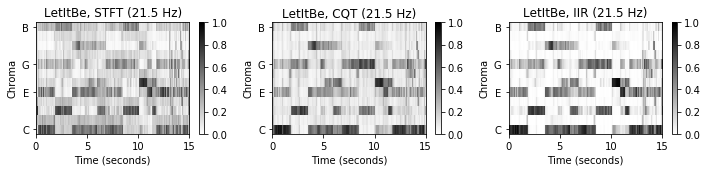

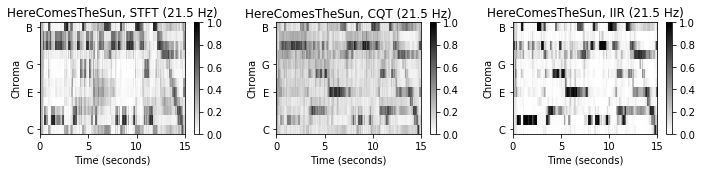

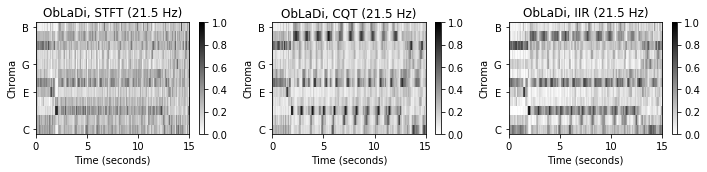

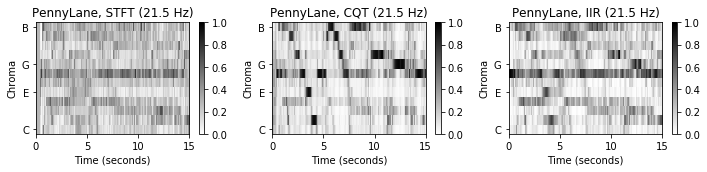

In [5]:
#Plot the chromagrams for each song
cmap='gray_r'
for item in selected_song:
    fig,ax=plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,1],
                                      'height_ratios':[1]}, figsize=(10,2.5))
    
    title = '%s, STFT (%0.1f Hz)' % (songs[item][0], fs_stft[item])
    libfmp.b.plot_chromagram(extraction_stft[item], Fs=fs_stft[item], ax=[ax[0]],  
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True, xlim=[0, 15])
    
    title = '%s, CQT (%0.1f Hz)' % (songs[item][0], fs_stft[item])
    libfmp.b.plot_chromagram(extraction_cqt[item], Fs=fs_cqt[item], ax=[ax[1]],  
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True, xlim=[0, 15])  

    title = '%s, IIR (%0.1f Hz)' % (songs[item][0], fs_iir[item])
    libfmp.b.plot_chromagram(extraction_iir[item], Fs=fs_iir[item], ax=[ax[2]],  
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True, xlim=[0, 15])      
    plt.tight_layout()   

# Chord Recognition Procedures

Given 24 major and minor triads, two pattern matching techniques were used for chord classification and recognition:

 - [Template Based Chord Recognition](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S2_ChordRec_Templates.html)
 - Hidden Markov Model Chord Recognition

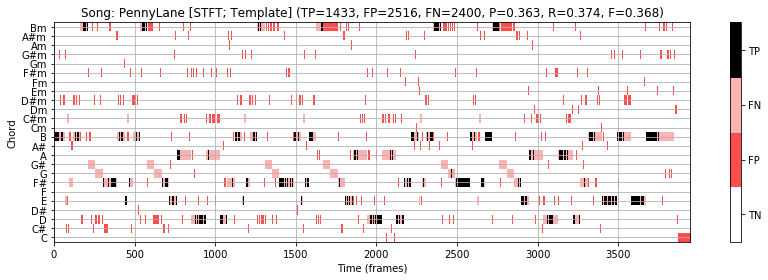

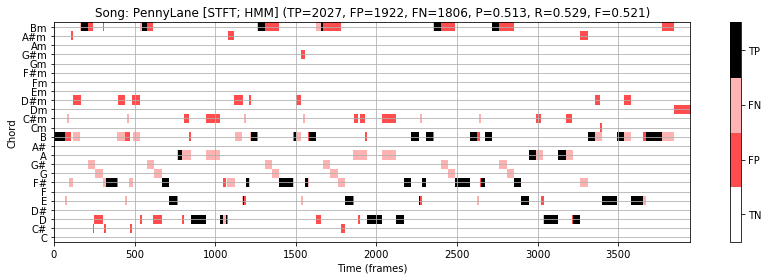

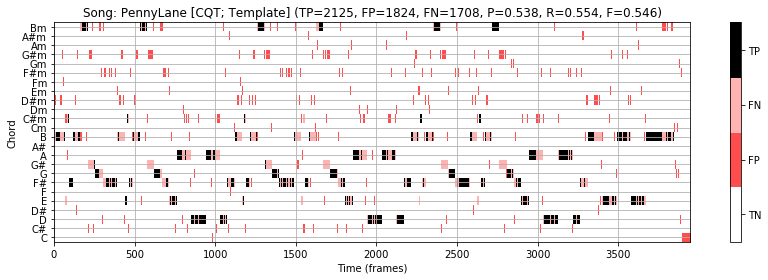

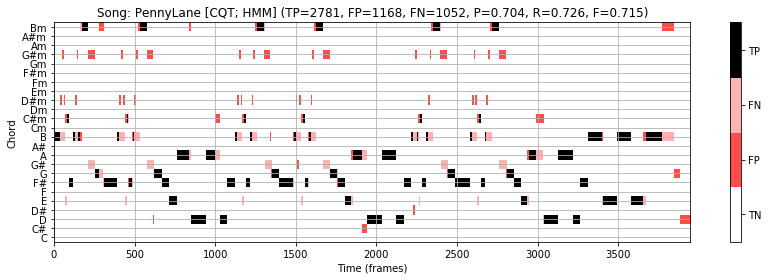

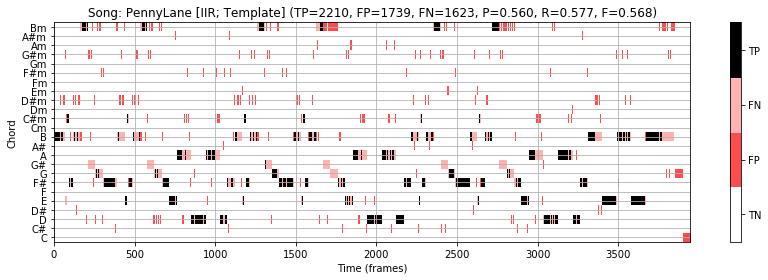

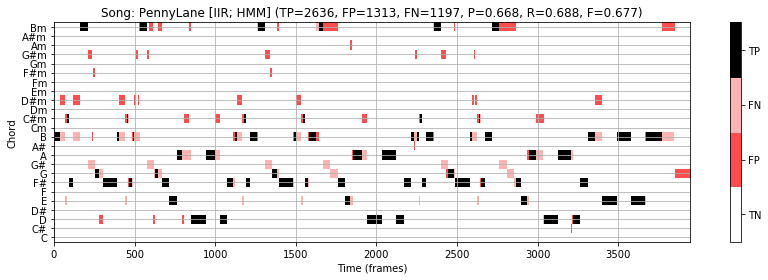

In [6]:
def recognize_chords(X,annotation,p=0.15,filter_length=None,filter_type='mean'):
    """
    Args:
        x (ndarray): chromagram 
        annotations (ndarray): matrix of reference annotation
        p (float) : Probability of self-transition for HMM 
        filter_length (int): Length of filter for prefiltering
        filter_type (str): Type of filter used for prefiltering. Mean or Median
    
    Return:
        result_tem (tuple): Evaluation metric for template based approach [P,R,F,TP,TP,FN]
        result_hmm (tuple): Evaluation metric for HMM based approach [P,R,F,TP,TP,FN]
        chord_tem (ndarray): Template based chord recognition 
        chord_hmm (ndarray): HMM based chord recognition 
        chord_rec (ndarray): Similarity matrix of chords
    """
    
    if filter_length is not None:
        if filter_type=='mean':
            X,Fs_x=libfmp.c3.smooth_downsample_feature_sequence(X, Fs=1, filt_len=filter_length,down_sampling=1)
        if filter_type=='median':
            X,Fs_x= libfmp.c3.median_downsample_feature_sequence(X,Fs=1,filt_len=filter_length,down_sampling=1)
    
    ### Chord recognition based on template ###
    chord_rec,chord_tem = libfmp.c5.chord_recognition_template(X,norm_sim='1')
    result_tem=libfmp.c5.compute_eval_measures(annotation, chord_tem)
    
    ### Chord recognition based on HMM ###
    a=libfmp.c5.uniform_transition_matrix(p=p)
    b_0=chord_rec
    c=1/24*np.ones((1,24))
    chord_hmm, _, _, _= libfmp.c5.viterbi_log_likelihood(a,c,b_0)
    result_hmm=libfmp.c5.compute_eval_measures(annotation,chord_hmm)
    return result_tem, result_hmm, chord_tem, chord_hmm, chord_rec


def plot_chord_recognition(annotation,results,chords,chord_label, xlim=None, Fs_x=1, title='',figsize=(12,4)):
    P,R,F,TP,FP,FN = results
    method='HMM' 
    title = title + ' (TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (TP, FP, FN, P, R, F)
    fig, ax, im = libfmp.c5.plot_matrix_chord_eval(annotation, chords, Fs=Fs_x, figsize=figsize,
                         title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_label)
    if xlim is not None:
        plt.xlim(xlim)
    plt.tight_layout()
    plt.show()
    

selected_song = [3]    
for item in selected_song:
    output = recognize_chords(extraction_stft[item], annotations_stft[item][0], p=0.15)
    result_tem, result_HMM, chord_tem, chord_HMM, chord_rec = output
    title = 'Song: %s [STFT; Template]' % songs[item][0]
    plot_chord_recognition(annotations_stft[item][0], result_tem, chord_tem, chord_labels, title=title)
    title = 'Song: %s [STFT; HMM]' % songs[item][0]
    plot_chord_recognition(annotations_stft[item][0], result_HMM, chord_HMM, chord_labels, title=title)

    output = recognize_chords(extraction_cqt[item], annotations_cqt[item][0], p=0.15)
    result_tem, result_HMM, chord_tem, chord_HMM, chord_rec = output
    title = 'Song: %s [CQT; Template]' % songs[item][0]
    plot_chord_recognition(annotations_cqt[item][0], result_tem, chord_tem, chord_labels, title=title)
    title = 'Song: %s [CQT; HMM]' % songs[item][0]
    plot_chord_recognition(annotations_cqt[item][0], result_HMM, chord_HMM, chord_labels, title=title)
    
    output = recognize_chords(extraction_iir[item], annotations_iir[item][0], p=0.15)
    result_tem, result_HMM, chord_tem, chord_HMM, chord_rec = output
    title = 'Song: %s [IIR; Template]' % songs[item][0]
    plot_chord_recognition(annotations_iir[item][0], result_tem, chord_tem, chord_labels, title=title)
    title = 'Song: %s [IIR; HMM]' % songs[item][0]
    plot_chord_recognition(annotations_iir[item][0], result_HMM, chord_HMM, chord_labels, title=title) 

The choice of chromagram has a great impact on chord recognition. CQT Based Chromagram with HMM created had the highest F Score

Based on this performance, view the F score of all the songs using a CQT Based Chromagram with HMM/


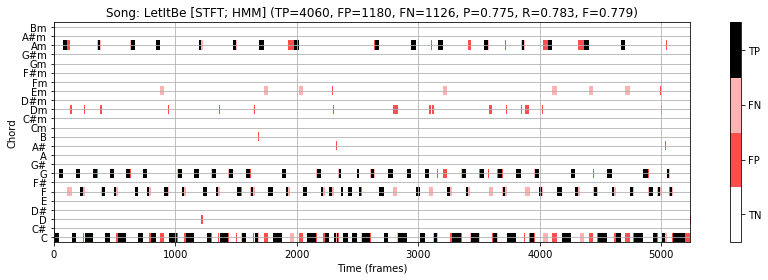

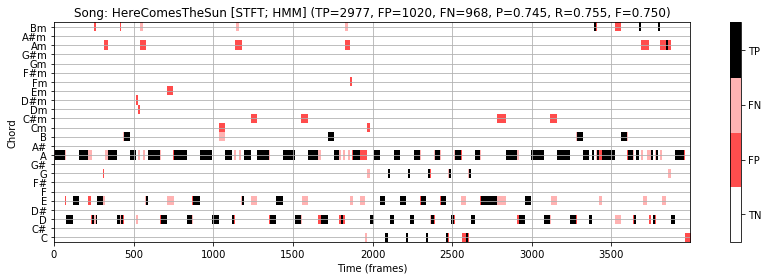

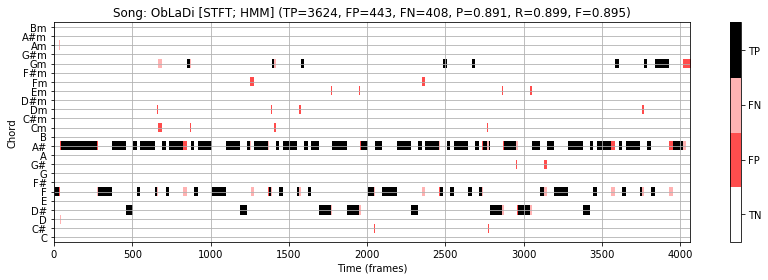

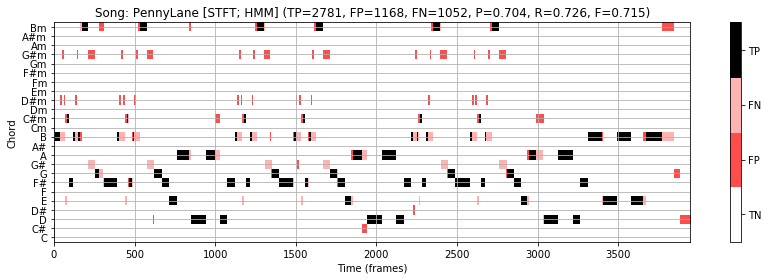

In [7]:
selected_song = [0,1,2,3]    
for item in selected_song:
    output = recognize_chords(extraction_cqt[item], annotations_cqt[item][0], p=0.15)
    result_tem, result_HMM, chord_tem, chord_HMM, chord_rec = output
    title = 'Song: %s [STFT; HMM]' % songs[item][0]
    plot_chord_recognition(annotations_cqt[item][0], result_HMM, chord_HMM, chord_labels, title=title)

Mean F score of all songs for a simple HMM is 0.785.

### Prefiltering

Investigate the effects of temporal smoothing on chromagram approaches. Two methods will be used for temporal smoothing :
 - Mean smoothing
 - Median smoothing

--------- Prefiltering with STFT Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane
--------- Prefiltering with CQT Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane
--------- Prefiltering with IIR Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane


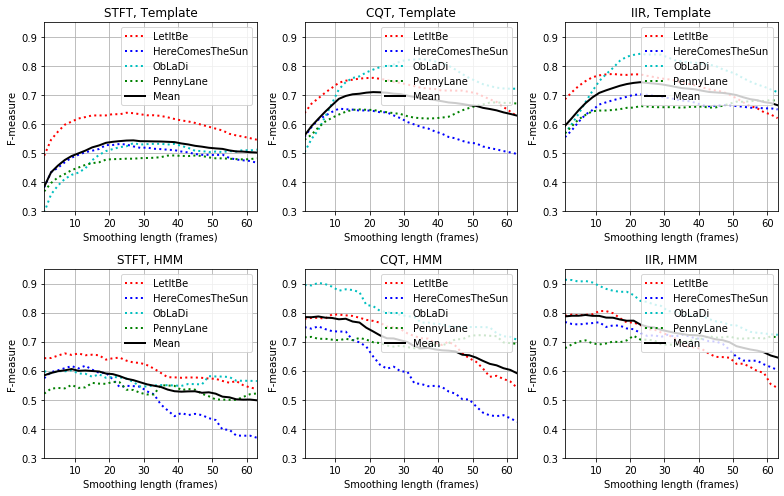

In [8]:
def calculate_mean(results,song):
    song_length=len(song)
    mean=np.copy(results[song[0]])
    for i in range(1,song_length):
        mean=mean+results[song[i]]
    mean=mean/song_length
    return mean

def plot_stats(parameters,songs, selected_song,results,axis,ylim=None,title='',xlabel='',ylabel='F-measure'):
    for i in selected_song:
        color=songs[i][1]
        song_id=songs[i][0]
        axis.plot(parameters,results[i],color=color, linestyle=':',linewidth='2',label=song_id)
    axis.plot(parameters,calculate_mean(results,selected_song),color='k',linestyle='-',linewidth='2',label='Mean')
    axis.legend(loc='upper right')
    axis.set_title(title)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.grid()
    if ylim is not None:
        axis.set_ylim(ylim)
    axis.set_xlim([parameters[0],parameters[-1]])
    
def chord_rec(selected_song,songs,X,annotations,parameters,
              parameter_type=None,p=0.15,filter_length=None, filter_type='mean'):
    """
     Args:

        selected_song (int): index to access specific song in songs list
        songs (ndarray): wav file and related directory to chord labels 
        annotations (dict): Time window of each chord labels 
        parameters (ndarray): List of smoothing windows 
        parameter_type (string): Filtering Method
        p (int): HMM self transition probability
        filter_type (string): Type of filter


    Return:
        extraction (dict): Chromgram output
        fs_dict (dict): Frequency of each window
        annotations (dict): Time window of each chord labels 
        chord_hmm (ndarray): HMM based chord recognition 
        chord_labels (list): All possible chord labels
    """
    param_length=len(parameters)
    F_tem=np.zeros(param_length)
    F_HMM=np.zeros(param_length)
    F_tem_dict={}
    F_HMM_dict={}
    for i in selected_songs:
        print('Extracting Features from {}'.format(songs[i][0]))
        for para in range(param_length):
            if parameter_type=='smooth':
                filter_length=parameters[para]
            if parameter_type=='p':
                p=parameters[para]

            out = recognize_chords(X[i], annotations[i][0],filter_length=filter_length,filter_type=filter_type,p=p)
            result_tem,result_HMM,chord_tem,chord_HMM,chord_rec=out
            F_tem[para]=result_tem[2]
            F_HMM[para]=result_HMM[2]
        F_tem_dict[i]=np.copy(F_tem)
        F_HMM_dict[i]=np.copy(F_HMM)
    return F_tem_dict,F_HMM_dict

selected_songs=[0,1,2,3]
parameters=(np.arange(32)*2)+1
print('--------- Prefiltering with STFT Based chromagarams ---------')
output_stft=chord_rec(selected_songs,songs,extraction_stft,annotations_stft,parameters,
                    parameter_type='smooth',p=0.15,filter_length=None,filter_type='mean')

print('--------- Prefiltering with CQT Based chromagarams ---------')
output_cqt=chord_rec(selected_songs,songs,extraction_cqt,annotations_cqt,parameters,
                    parameter_type='smooth',p=0.15,filter_length=None,filter_type='mean')

print('--------- Prefiltering with IIR Based chromagarams ---------')
output_iir=chord_rec(selected_songs,songs,extraction_iir,annotations_iir,parameters,
                    parameter_type='smooth',p=0.15,filter_length=None,filter_type='mean')


# Plot result
fig, ax = plt.subplots(2, 3, figsize=(11, 7))
xlabel='Smoothing length (frames)'
ylim = [0.3, 0.95]
title='STFT, Template'
plot_stats(parameters, songs, selected_songs, output_stft[0], ax[0, 0], 
                ylim=ylim, title=title, xlabel=xlabel)

title='STFT, HMM'
plot_stats(parameters, songs, selected_songs, output_stft[1], ax[1, 0], 
                ylim=ylim, title=title, xlabel=xlabel)
title='CQT, Template'                           
plot_stats(parameters, songs, selected_songs, output_cqt[0], ax[0, 1], 
                ylim=ylim, title=title, xlabel=xlabel)
title='CQT, HMM'
plot_stats(parameters, songs, selected_songs, output_cqt[1], ax[1, 1], 
                ylim=ylim, title=title, xlabel=xlabel)
title='IIR, Template'                           
plot_stats(parameters, songs, selected_songs, output_iir[0], ax[0, 2], 
                ylim=ylim, title=title, xlabel=xlabel)
title='IIR, HMM'
plot_stats(parameters, songs, selected_songs, output_iir[1], ax[1, 2], 
                ylim=ylim, title=title, xlabel=xlabel)
plt.tight_layout()  

For template based approaches, smoothing increases performance by removing sudden fluctuations and outliers.

For HMM based approaches, temporal smoothing decreases the performance of the model.

### Updating Self Transition Probabilities

For HMM approaches, the self-transition probability is the probability for an event to repeat. As this probability is unknown, the most optimal probability will be investigated. 

--------- Self Transition Probabilities using STFT Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane
--------- Self Transition Probabilities Prefiltering with CQT Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane
--------- Self Transition Probabilities Prefiltering with IIR Based chromagarams ---------
Extracting Features from LetItBe
Extracting Features from HereComesTheSun
Extracting Features from ObLaDi
Extracting Features from PennyLane


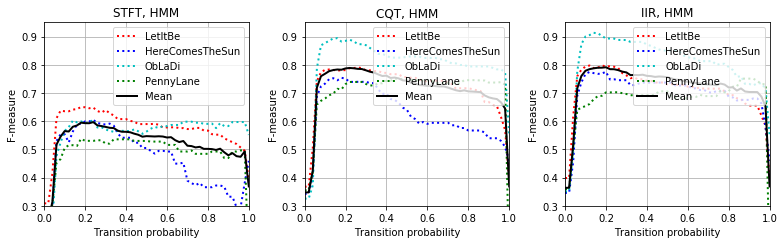

In [9]:
selected_song=[0,1,2,3]
parameters=(np.arange(51))*0.02

print('--------- Self Transition Probabilities using STFT Based chromagarams ---------')
output_stft=chord_rec(selected_songs,songs,extraction_stft,annotations_stft,parameters,
                    parameter_type='p',p=0.15,filter_length=None)

print('--------- Self Transition Probabilities Prefiltering with CQT Based chromagarams ---------')
output_cqt=chord_rec(selected_songs,songs,extraction_cqt,annotations_cqt,parameters,
                    parameter_type='p',p=0.15,filter_length=None)

print('--------- Self Transition Probabilities Prefiltering with IIR Based chromagarams ---------')
output_iir=chord_rec(selected_songs,songs,extraction_iir,annotations_iir,parameters,
                    parameter_type='p',p=0.15,filter_length=None)

fig, ax = plt.subplots(1,3, figsize=(11, 3.5))
xlabel='Transition probability'
ylim = [0.3, 0.95]
title='STFT, HMM'
plot_stats(parameters, songs, selected_song, output_stft[1], ax[0], ylim=ylim, title=title, xlabel=xlabel)
title='CQT, HMM'
plot_stats(parameters, songs, selected_song, output_cqt[1], ax[1], ylim=ylim, title=title, xlabel=xlabel)
title='IIR, HMM'
plot_stats(parameters, songs, selected_song, output_iir[1], ax[2], ylim=ylim, title=title, xlabel=xlabel)
plt.tight_layout()  

## Class Imbalance

Automated chord recognition requires simplified representations of the chords. Metrics such as F-measure is limited in the information you can obtain on the relevance of the recognition. To investigate, use a basic recognizer that determines a single major or minor chord for the some and output the same label for the entire duration of the song.  

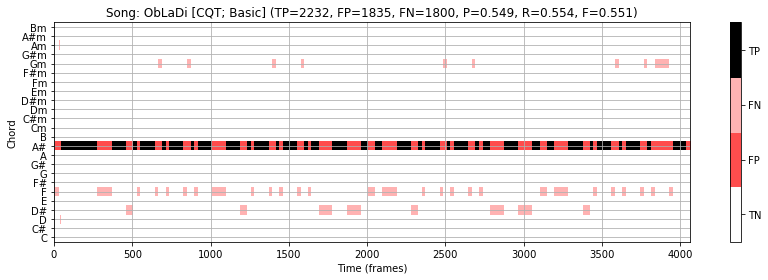

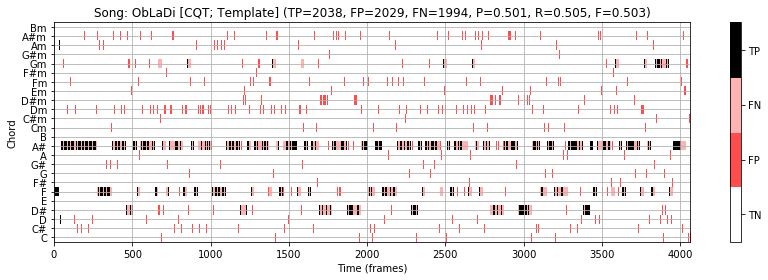

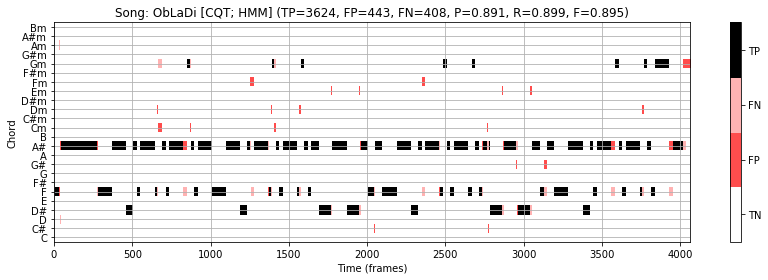

In [10]:
for i in [2]:
    output = recognize_chords(extraction_cqt[i],annotations_cqt[i][0],p=0.15)
    result_tem, result_HMM, chord_tem, chord_HMM, chord_rec = output
    chord_baseline = np.zeros(chord_tem.shape)
    chord_baseline[10, :] = 1    
    result_baseline = libfmp.c5.compute_eval_measures(annotations_cqt[i][0], chord_baseline)    

    title='Song: %s [CQT; Basic]' % songs[i][0]
    plot_chord_recognition(annotations_cqt[i][0], result_baseline,
                                  chord_baseline, chord_labels, title=title)
    title='Song: %s [CQT; Template]' % songs[i][0]
    plot_chord_recognition(annotations_cqt[i][0], result_tem, 
                                  chord_tem, chord_labels, title=title)
    title='Song: %s [CQT; HMM]' % songs[i][0]
    plot_chord_recognition(annotations_cqt[i][0], result_HMM, 
                                  chord_HMM, chord_labels, title=title)

Even with labelling all chords as B major, the basic model has an F score of 0.55. Evident that there can be very high class imbalance when it comes to chord frequency for a specific song. 

## Chord Reduction

For simplifications, chord variations such as seventh, diminished and augmented were reduced to be a major or minor chord. This type of simplification is called triad reduction. To investigate the impact of simplifications, another method of representation was uesd. Non-chord reduction was used which replaces these chord variations with a non-chord label, effectively creating 25 classes. 

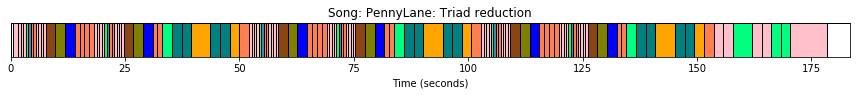

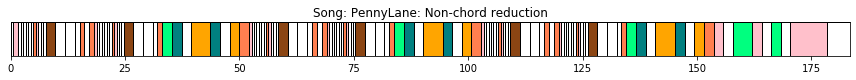

In [11]:
#Visualize differences in triad and non-chord reductions
for i in [3]:
    song_id=songs[i][0]
    annotated=songs[i][3]
    annotated_orig=annotated.replace('_simplified','')
    
    orig_anno,_=libfmp.c4.read_structure_annotation(annotated_orig)
    anno,_=libfmp.c4.read_structure_annotation(annotated)
    
    for j in range(len(anno)):
        if anno[j][2]!=orig_anno[j][2]:
            orig_anno[j][2]='N'
            
    libfmp.b.plot_segments(anno, figsize=(12, 1.2), time_label='Time (seconds)', 
                           print_labels=False, colors=color_ann, alpha=1)
    plt.title('Song: %s: Triad reduction' % song_id)    
    plt.show()
    libfmp.b.plot_segments(orig_anno, figsize=(12, 1), 
                           print_labels=False, colors=color_ann, alpha=1)
    plt.title('Song: %s: Non-chord reduction' % song_id)
    plt.show()

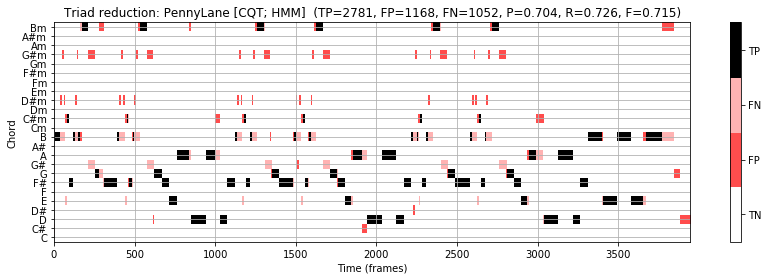

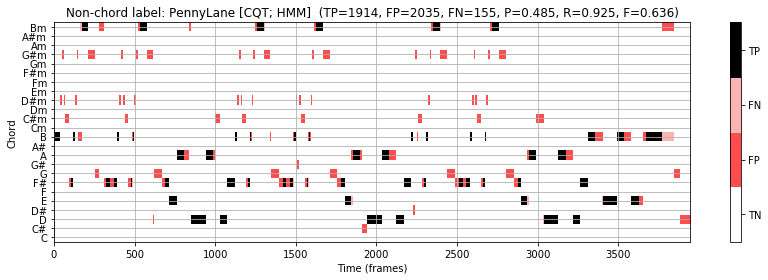

In [12]:
for i in [3]:
    output = recognize_chords(extraction_cqt[i], annotations_cqt[i][0], p=0.15)
    result_tem, result_HMM, chord_tem, chord_HMM, chord_rec = output
    song_id = songs[i][0]
    simp = songs[i][3]
    anno = simp.replace('_simplified', '')    
    ann_orig, _ = libfmp.c4.read_structure_annotation(anno)
    out =  libfmp.c5.convert_chord_ann_matrix(anno, chord_labels, Fs=fs_cqt[i],
                                                 N=extraction_cqt[i].shape[1], last=False)    
    ann_matrix = out[0]    
    output = recognize_chords(extraction_cqt[i], ann_matrix, p=0.15)
    result_tem_N, result_HMM_N, chord_tem_N, chord_HMM_N, chord_rec_N = output    
    
    title = 'Triad reduction: %s [CQT; HMM] ' % songs[i][0]
    plot_chord_recognition(annotations_cqt[i][0], result_HMM, chord_HMM, chord_labels, title=title)    
    title = 'Non-chord label: %s [CQT; HMM] ' % songs[i][0]
    plot_chord_recognition(ann_matrix, result_HMM_N, chord_HMM_N, chord_labels, title=title)

Performing non-chord reduction caused a decrease in model performance, perhaps due to significantly decreasing the chord labels.

Assess model performance with optimal parameters obtains through the multiple investigations

In [13]:
selected_song = [0,1,2,3]    
precision=[]
recall=[]
f_score=[]
for item in selected_song:
    output = recognize_chords(extraction_cqt[item], annotations_cqt[item][0], p=0.15)
    result_tem, result_HMM, chord_tem, chord_HMM, chord_rec = output
    title = 'Song: %s [STFT; HMM]' % songs[item][0]
    P,R,F,TP,FP,FN = result_HMM
    precision.append(P)
    recall.append(R)
    f_score.append(F)
    

print('----- Precision : {:.2f} '.format(np.array(precision).mean()))
print('----- Recall : {:.2f}  '.format(np.array(recall).mean()))
print('----- F Score : {:.2f} '.format(np.array(f_score).mean()))

----- Precision : 0.78 
----- Recall : 0.79  
----- F Score : 0.78 
